# VMO2 Take Home Test

This notebook contains the experiments that led to the creation of the final `task1.py` script.

In [50]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [51]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils import generate_datasets, generate_metrics
from utils.variables import (
    data_url,
    label_mapping,
    object_cols,
    ordinal_cols,
    random_state,
    y_label,
)


## 0 - Loading the Data

Before we begin any experimentation we load the data from the specified GCS bucket into a pandas dataframe before splitting into the required 60/20/20 train, val, test splits.

In [52]:
x_train, y_train, x_val, y_val, x_test, y_test = generate_datasets(
    data_url, y_label, random_state, label_mapping
)

## 1 - Creating a Naive Baseline

To test that the final model performs well, we set up a naive baseline model that simply takes the mean age of the training data and predicts pets below the mean age are adopted and those above are not. This is under the assumption that people have a strong preference for younger pets.

In [53]:
# Data will only consist of the Age column
x_train_naive = x_train["Age"]
x_val_naive = x_val["Age"]
x_test_naive = x_test["Age"]

In [54]:
class Naive_Model:
    def __init__(self, x_train):
        self.mean = x_train.mean()

    def predict(self, X):
        return X.apply(lambda row: 1 if row < self.mean else 0)

In [55]:
# Generate predictions
naive_model = Naive_Model(x_train=x_train_naive)
y_pred_naive = naive_model.predict(x_test_naive)

In [56]:
# Evaluation
naive_f1, naive_acc, naive_recall, naive_roc_auc = generate_metrics(y_test, y_pred_naive)
print(
    f"Model Evaluation Metrics:\nF1 Score: {naive_f1}\nAccuracy: {naive_acc}\nRecall: {naive_recall}\nROC AUC: {naive_roc_auc}"
)

Model Evaluation Metrics:
F1 Score: 0.7808260476334036
Accuracy: 0.6850086655112652
Recall: 0.7759137207908927
ROC AUC: 0.6117440278445856


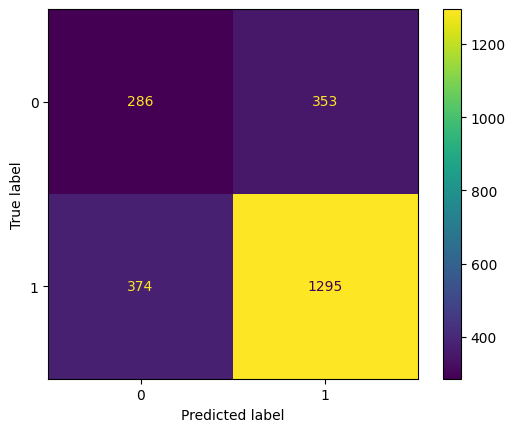

In [57]:
cm = confusion_matrix(y_test, y_pred_naive)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [58]:
# Count number of pets below mean age and above
# naive_model.mean
pos_count_naive = (x_test_naive < naive_model.mean).sum()
neg_count_naive = len(x_test_naive) - pos_count_naive

print(f"There are {pos_count_naive} pets under the mean age of {naive_model.mean} and {neg_count_naive} above this mean age")

There are 1648 pets under the mean age of 11.458971395550419 and 660 above this mean age


We can see from this initial naive model is good at classifying pets that were adopted but for ones that weren't it was almost a 50/50 guess. This result could be attributed the fact that the majority of pets (1648 out of 2308) are under the the mean age of 11.46 years. Also if we look at the figure below we can see that there is heavy class imbalance so since the majority of the labels are positive (i.e. adopted) and since the majority of pets are under the age of 11.46 years a naive model would perform well.

<Axes: ylabel='Adopted'>

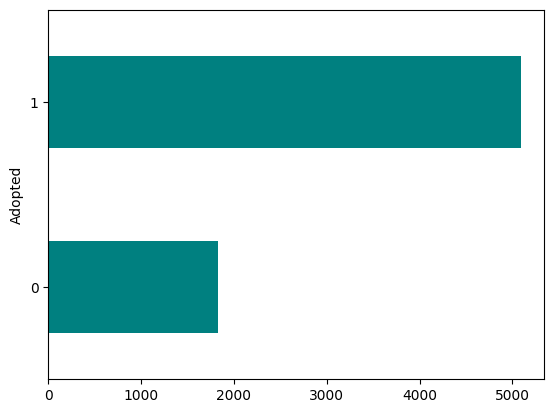

In [59]:
y_train.value_counts().sort_index().plot(kind='barh', color='teal')

## 2 - Basic ML

Now we have our naive baseline we would like to test how well a simple XGBoost model performs. To ensure that categorical data columns can be consumed by the model we do a very basic transformation to encode the object columns as an enumerated type.

This will provide base level metrics for:
1. How much better (or worse) a simple XGBoost model is over the naive baseline
2. Provide a baseline from which we can assess if feature engineering provides an improvement

In [60]:
# Separate categorical and numerical cols
num_cols = x_train._get_numeric_data().columns
cat_cols = list(set(x_train.columns) - set(num_cols))

In [61]:
# Make a copy of the dataset for transformation
x_train_base = x_train.copy(deep=True)
x_val_base = x_val.copy(deep=True)
x_test_base = x_test.copy(deep=True)

In [62]:
# Use pd.factorize to encode object cols as enumerated types that can be consumed by the XGBoost model
indexer = {}
for col in cat_cols:
    _, indexer[col] = pd.factorize(x_train_base[col].astype(str))

for col in cat_cols:
    x_train_base[col] = indexer[col].get_indexer(x_train_base[col].astype(str))
    x_val_base[col] = indexer[col].get_indexer(x_val_base[col].astype(str))
    x_test_base[col] = indexer[col].get_indexer(x_test_base[col].astype(str))

In [63]:
# Defining the model
base_model = xgb.XGBClassifier(
    random_state=random_state,
    early_stopping_rounds=10,
    objective="binary:logistic",
)

# Train
base_model.fit(
    x_train_base,
    y_train,
    eval_set=[(x_train_base, y_train), (x_val_base, y_val)],
)

[0]	validation_0-logloss:0.53780	validation_1-logloss:0.53993
[1]	validation_0-logloss:0.51370	validation_1-logloss:0.51978
[2]	validation_0-logloss:0.49615	validation_1-logloss:0.50728
[3]	validation_0-logloss:0.48523	validation_1-logloss:0.50072
[4]	validation_0-logloss:0.47711	validation_1-logloss:0.49672
[5]	validation_0-logloss:0.46750	validation_1-logloss:0.49084
[6]	validation_0-logloss:0.46141	validation_1-logloss:0.48710
[7]	validation_0-logloss:0.45354	validation_1-logloss:0.48701
[8]	validation_0-logloss:0.44806	validation_1-logloss:0.48505
[9]	validation_0-logloss:0.44277	validation_1-logloss:0.48496
[10]	validation_0-logloss:0.43795	validation_1-logloss:0.48481
[11]	validation_0-logloss:0.43245	validation_1-logloss:0.48555
[12]	validation_0-logloss:0.42960	validation_1-logloss:0.48696
[13]	validation_0-logloss:0.42581	validation_1-logloss:0.48745
[14]	validation_0-logloss:0.42143	validation_1-logloss:0.48908


[15]	validation_0-logloss:0.41844	validation_1-logloss:0.48906
[16]	validation_0-logloss:0.41517	validation_1-logloss:0.48887
[17]	validation_0-logloss:0.41268	validation_1-logloss:0.48879
[18]	validation_0-logloss:0.41179	validation_1-logloss:0.49013
[19]	validation_0-logloss:0.40909	validation_1-logloss:0.49014
[20]	validation_0-logloss:0.40760	validation_1-logloss:0.49003


/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [64]:
# Prediction
y_pred_base = base_model.predict(x_test_base)

# Evaluation
base_f1, base_acc, base_recall, base_roc_auc = generate_metrics(y_test, y_pred_base)
print(
    f"Model Evaluation Metrics:\nF1 Score: {base_f1}\nAccuracy: {base_acc}\nRecall: {base_recall}\nROC AUC: {base_roc_auc}"
)

Model Evaluation Metrics:
F1 Score: 0.8451169188445666
Accuracy: 0.7560658578856152
Recall: 0.920311563810665
ROC AUC: 0.6236925581181652


/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

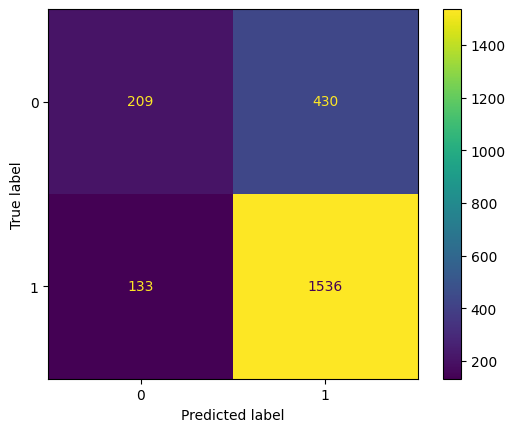

In [65]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

We can see that there is an increase in accuracy, f1 score and recall although these figures are misleading. If we look at the ROC AUC we can see that this is lower than the naive model indicating poorer performance in terms of it's ability to classify between the adopted and not adopted classes. If we look at the confusion matrix we can see why this is the case. The model seems to just predict most of the pets are adopted as we can see that there are much more false positives than true negatives.

## 3 - Feature Engineered Model

We now attempt to feature engineer some of the columns in our dataset in hope of trying to increase the model performance.

First we could look into the numerical columns. In our base model we did not touch these values. Lets take a look at their distributions:

In [66]:
x_train.describe()

,Age,Fee,PhotoAmt
count,6922.000000,6922.000000,6922.000000
mean,11.458971,22.888760,3.626697
std,18.372476,78.356008,3.149628
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000
50%,4.000000,0.000000,3.000000
75%,12.000000,0.000000,5.000000
max,180.000000,2000.000000,30.000000


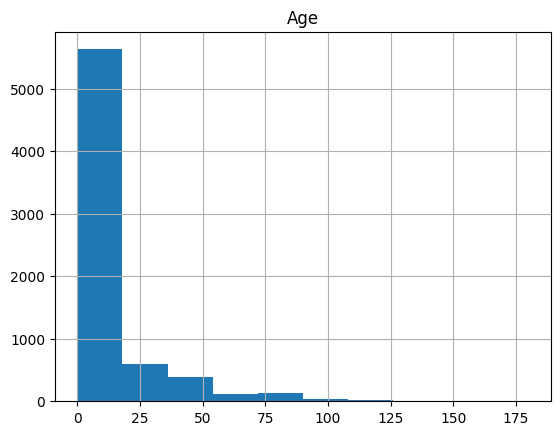

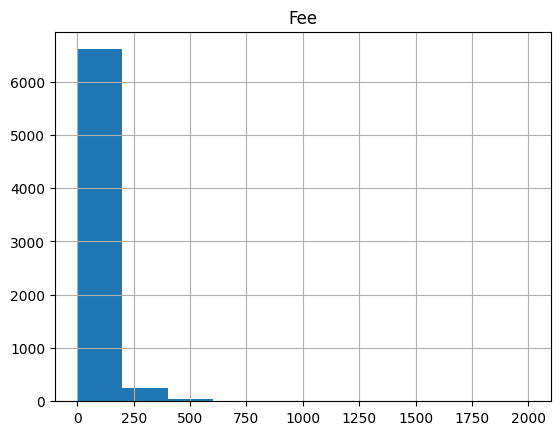

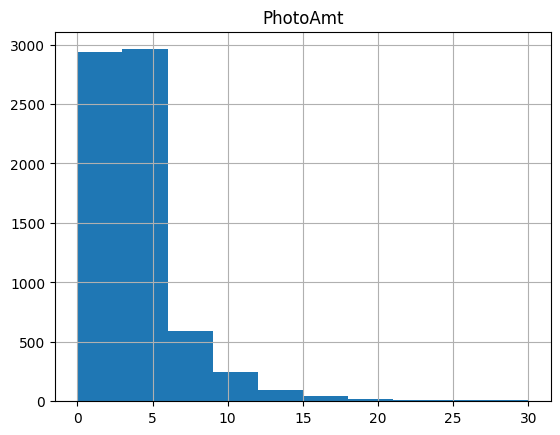

In [67]:
for col in num_cols:
    x_train[col].hist()
    plt.title(col)
    plt.show()

We can see that all numercial columns are heavily positively skewed. To rectify that we could log transform them

In [68]:
x_train[num_cols] = x_train[num_cols].transform([np.log1p])
x_val[num_cols] = x_val[num_cols].transform([np.log1p])
x_test[num_cols] = x_test[num_cols].transform([np.log1p])

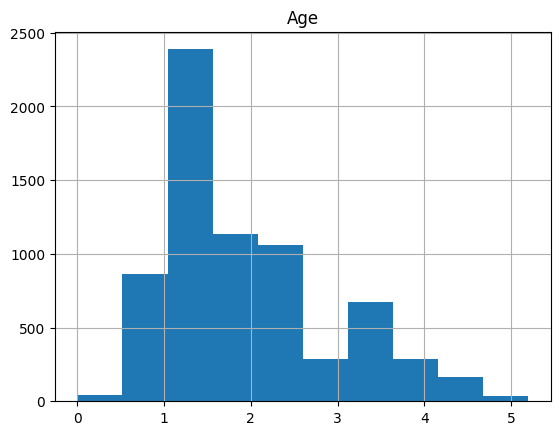

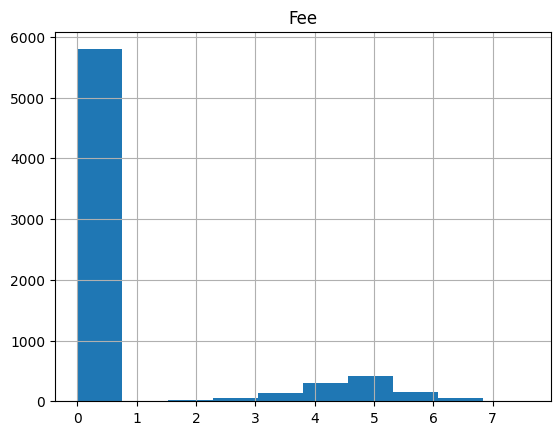

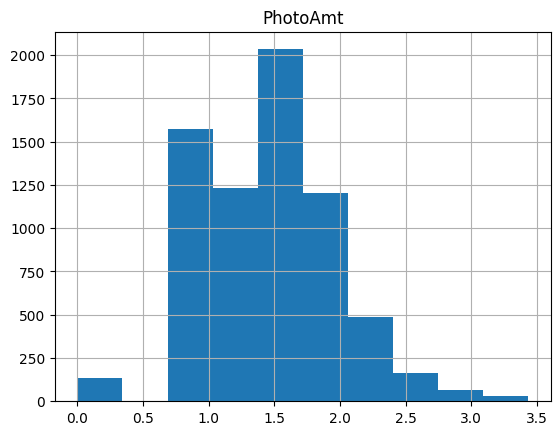

In [69]:
for col in num_cols:
    x_train[col].hist()
    plt.title(col)
    plt.show()

PhotoAmt and Age seems to have benefited from this transformation but not so much Fee. Perhaps this should be a boolean column of `Is_Fee`

In [70]:
fee_transformed = (x_train["Fee"] != 0)

print(f"{(fee_transformed == 0).sum()} are 0\n{(fee_transformed == 1).sum()} are 1")

5762 are 0
1160 are 1


We can see that most of these rows are 0 so having a boolean may enrich our model's ability to learn something from this column

In [71]:
x_train["Fee"] = fee_transformed
x_val["Fee"] = (x_val["Fee"] != 0)
x_test["Fee"] = (x_test["Fee"] != 0)

We could also look into the categorical columns. In our base model we naively converted them all into an ordinal encoding. This time we could look to make more meaningful transformations

In [72]:
for col in cat_cols:
    print(f"{col}: {x_train[col].unique()}")

Gender: ['Female' 'Male']
Color1: ['Black' 'Golden' 'Brown' 'Gray' 'White' 'Cream' 'Yellow']
Color2: ['No Color' 'Golden' 'Brown' 'White' 'Cream' 'Gray' 'Yellow']
MaturitySize: ['Medium' 'Large' 'Small']
FurLength: ['Short' 'Medium' 'Long']
Type: ['Dog' 'Cat']
Health: ['Healthy' 'Minor Injury' 'Serious Injury']
Breed1: ['Mixed Breed' 'Domestic Short Hair' 'Domestic Medium Hair' 'Tabby'
 'Bengal' 'Siamese' 'Poodle' 'Domestic Long Hair' 'Pointer' 'Rottweiler'
 'Dachshund' 'Shih Tzu' 'Labrador Retriever' 'German Shepherd Dog'
 'Black Labrador Retriever' 'Persian' 'Jack Russell Terrier'
 'English Bulldog' 'Pug' 'Siberian Husky' 'Burmilla' 'Terrier'
 'Maine Coon' 'Tonkinese' 'Pomeranian' 'Dalmatian' 'Schnauzer'
 'Oriental Short Hair' 'Shar Pei' 'Golden Retriever' 'British Shorthair'
 'Miniature Pinscher' 'Calico' 'Doberman Pinscher' 'Weimaraner' 'Beagle'
 'Silky Terrier' 'Old English Sheepdog' 'Burmese'
 'Yellow Labrador Retriever' 'Cocker Spaniel' 'Spitz' 'Havana'
 'Russian Blue' 'Jack Rus

The following columns might make more sense to be one hot coded instead seen as the category values seem to bear no relationship between them:
1. Color 1
2. Color 2
3. Gender
4. Type
3. Sterilised
4. Vaccinated

In [73]:
object_cols = ["Gender", "Type", "Color1", "Color2", "Sterilized", "Vaccinated"]

OH_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False, drop="if_binary")
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(x_train[object_cols]))
OH_cols_val = pd.DataFrame(OH_encoder.transform(x_val[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(x_test[object_cols]))

OH_cols_train.index = x_train.index
OH_cols_val.index = x_val.index
OH_cols_test.index = x_test.index

non_OH_x_train = x_train.drop(object_cols, axis=1)
non_OH_x_val = x_val.drop(object_cols, axis=1)
non_OH_x_test = x_test.drop(object_cols, axis=1)

x_train = pd.concat([non_OH_x_train, OH_cols_train], axis=1)
x_val = pd.concat([non_OH_x_val, OH_cols_val], axis=1)
x_test = pd.concat([non_OH_x_test, OH_cols_test], axis=1)

/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The following columns might make more sense to be ordinally encoded since the values for these categories seems to have an ordinal relationship:
1. Fur length
2. Health
5. Maturitysize

In [74]:
ordinal_cols = ["FurLength", "Health", "MaturitySize"]

ord_encoder = OrdinalEncoder(categories=[["Short", "Medium", "Long"], ['Healthy', 'Minor Injury', 'Serious Injury'], ['Small', 'Medium', 'Large']])
x_train[ordinal_cols] = ord_encoder.fit_transform(x_train[ordinal_cols])
x_val[ordinal_cols] = ord_encoder.transform(x_val[ordinal_cols])
x_test[ordinal_cols] = ord_encoder.transform(x_test[ordinal_cols])

In the interest of time we are dropping breed names but would have explored creating buckets via K-means clustering or TF-IDF vectorisation to create a more meaningful feature out of this.

In [75]:
x_train = x_train.drop(["Breed1"], axis=1)
x_val = x_val.drop(["Breed1"], axis=1)
x_test = x_test.drop(["Breed1"], axis=1)

This time we are adding in a couple of hyperparams to improve model performance:
1. The number of estimators has been changed to 40
2. Max depth of each tree has been reduced to 4 to reduce overfitting
3. A scale_pos_weight parameter has been set to 0.4. This is said to help deal with unbalanced classes and as a rule of thumb should be set to `sum(negative instances) / sum(positive instances)`

In [76]:
# Defining the model
fe_model = xgb.XGBClassifier(
    random_state=random_state,
    max_depth=4,
    n_estimators=40,
    scale_pos_weight=0.4,
    early_stopping_rounds=10,
    eval_metric="aucpr",
    objective="binary:logistic",
)

# Train
fe_model.fit(
    x_train,
    y_train,
    eval_set=[(x_train,y_train), (x_val, y_val)],
)

[0]	validation_0-aucpr:0.86339	validation_1-aucpr:0.85725
[1]	validation_0-aucpr:0.87295	validation_1-aucpr:0.88136
[2]	validation_0-aucpr:0.87632	validation_1-aucpr:0.88166


[3]	validation_0-aucpr:0.88168	validation_1-aucpr:0.88626
[4]	validation_0-aucpr:0.88599	validation_1-aucpr:0.88724
[5]	validation_0-aucpr:0.88764	validation_1-aucpr:0.88796
[6]	validation_0-aucpr:0.88940	validation_1-aucpr:0.88760
[7]	validation_0-aucpr:0.89197	validation_1-aucpr:0.88841
[8]	validation_0-aucpr:0.89349	validation_1-aucpr:0.88909
[9]	validation_0-aucpr:0.89442	validation_1-aucpr:0.88849
[10]	validation_0-aucpr:0.89613	validation_1-aucpr:0.88861
[11]	validation_0-aucpr:0.89715	validation_1-aucpr:0.88896
[12]	validation_0-aucpr:0.89841	validation_1-aucpr:0.88958
[13]	validation_0-aucpr:0.89945	validation_1-aucpr:0.88872
[14]	validation_0-aucpr:0.90047	validation_1-aucpr:0.88947
[15]	validation_0-aucpr:0.90100	validation_1-aucpr:0.88926
[16]	validation_0-aucpr:0.90340	validation_1-aucpr:0.88955
[17]	validation_0-aucpr:0.90395	validation_1-aucpr:0.88892


/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[18]	validation_0-aucpr:0.90466	validation_1-aucpr:0.88966
[19]	validation_0-aucpr:0.90563	validation_1-aucpr:0.88923
[20]	validation_0-aucpr:0.90597	validation_1-aucpr:0.88847
[21]	validation_0-aucpr:0.90697	validation_1-aucpr:0.88768
[22]	validation_0-aucpr:0.90718	validation_1-aucpr:0.88724
[23]	validation_0-aucpr:0.90778	validation_1-aucpr:0.88672
[24]	validation_0-aucpr:0.90860	validation_1-aucpr:0.88718
[25]	validation_0-aucpr:0.90946	validation_1-aucpr:0.88688
[26]	validation_0-aucpr:0.91008	validation_1-aucpr:0.88753
[27]	validation_0-aucpr:0.91064	validation_1-aucpr:0.88745
[28]	validation_0-aucpr:0.91142	validation_1-aucpr:0.88760


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [77]:
# Prediction
y_pred_fe = fe_model.predict(x_test)

# Evaluation
fe_f1, fe_acc, fe_recall, fe_roc_auc = generate_metrics(y_test, y_pred_fe)
print(
    f"Model Evaluation Metrics:\nF1 Score: {fe_f1}\nAccuracy: {fe_acc}\nRecall: {fe_recall}\nROC AUC: {fe_roc_auc}"
)

Model Evaluation Metrics:
F1 Score: 0.76817737202478
Accuracy: 0.6919410745233969
Recall: 0.7058118633912522
ROC AUC: 0.6807619567347497


/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/hirurana/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

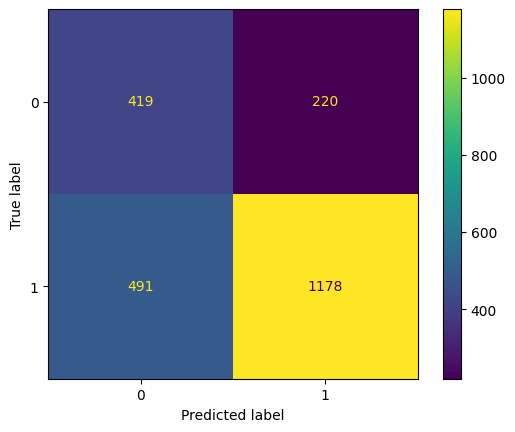

In [78]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_fe)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Interestingly we see a decrease in f1_score, recall and accuracy (compared to the base model), which might initially suggest that this model hasn't performed well but when looking at the ROC AUC we see a decent lift indicating that this model may perform better at predicting both classes. This deduction is confirmed when looking at the confusion matrix. We can see that although the model performs worse in classifying the positve class, there is signficant improvement in the model's ability to classify the negative class. Though this model isn't perfect, it is certainly better than where we started.

The script provided in `task1.py` will contain a cleaned up and optimised version of this third feature engineered model